In [1]:
import numpy as np
from dipy.reconst.ivim import IvimModel
from dipy.data.fetcher import read_ivim
import dipy.core.gradients as dpg
import matplotlib.pyplot as plt

from dipy.reconst.base import ReconstModel
from dipy.reconst.multi_voxel import multi_voxel_fit

% matplotlib inline

In [2]:
img, gtab = read_ivim()
data = img.get_data()

print('data.shape (%d, %d, %d, %d)' % data.shape)

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/shahnawaz/.dipy/ivim 
data.shape (256, 256, 54, 21)


In [3]:
z = 33
x1, x2 = 90, 150
y1, y2 = 90, 180

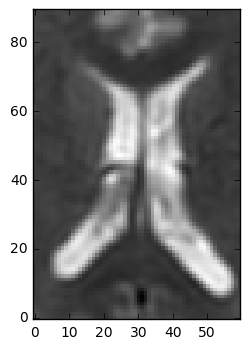

In [4]:
# Plot at b=0
b_val = 0
plt.imshow(data[x1:x2, y1:y2, z, b_val].T, origin='lower',
           cmap="gray", interpolation='nearest')
plt.show("CSF_slice.png")
plt.close()

In [5]:
# We'll look at a 2-by-2-by-2 cube
data_slice = data[90:92, 90:92, 33:35, :]

In [6]:
gtab.bvecs.shape

(21, 3)

In [7]:
data_slice.shape

(2, 2, 2, 21)

In [8]:
def nmse(data, prediction):
    """
    Compute the normalized mean squared error.
    """
    return (((data - prediction)**2).mean())/sum(data**2)

In [9]:
def leave_one_cross(model, data, data_slice, gtab):
    """
    Performs a leave one out cross validation and returns the prediction and normalised mean sq error
    """
    # Preallocate an array for the results:
    predictions = np.zeros([data_slice.shape[0], 
                            data_slice.shape[1],
                            data_slice.shape[2],
                            data_slice.shape[3] - 1])

    # Normalized mean sq error
    NMSE = []
    # Note that we are not predicting S0, because we always need S0 to fit the model

    for left_out in range(1, data.shape[-1]-1):
        # These are the b-values/b-vectors with one of them left out:
        left_out_bvals = np.concatenate([gtab.bvals[:left_out], gtab.bvals[left_out+1:]])
        left_out_bvecs = np.concatenate([gtab.bvecs[:left_out], gtab.bvecs[left_out+1:]])
        left_out_gtab = dpg.gradient_table(left_out_bvals, left_out_bvecs)
        # Create a model for this iteration
        current_model = model(left_out_gtab)
        # We fit to the data leaving out the current measurement
        left_out_data = np.concatenate([data_slice[..., :left_out], 
                                        data_slice[..., left_out+1:]], -1)
        fit = current_model.fit(left_out_data)
        # We try to predict only the left out measurement
        predict_gtab = dpg.gradient_table(np.array([gtab.bvals[left_out]]), 
                                          np.array([gtab.bvecs[left_out]]))
        predictions[..., left_out] = fit.predict(predict_gtab, S0=data_slice[..., 0]).squeeze()
        err = nmse(predictions[..., left_out].ravel(), data_slice[..., left_out].ravel())

        NMSE += [err]
    return (predictions, np.array(NMSE))

In [10]:
ivim_predictions, ivim_nmse = leave_one_cross(IvimModel, data, data_slice, gtab)
print(ivim_nmse)

[  3.63755063e-05   1.67682023e-05   4.36967951e-05   2.25478399e-05
   8.03281451e-05   6.64135636e-05   5.63040222e-05   1.30920499e-04
   1.61843183e-05   2.86534074e-05   9.41812937e-05   3.41098305e-05
   7.74138203e-05   4.73957959e-04   1.97309603e-04   8.21625160e-05
   1.62972001e-05   1.73980449e-04   1.22268685e-05]


In [11]:
def exponential_prediction(params, gtab, S0 = 1.):
    """
    Prediction using exponential decay model.
    """
    b = gtab.bvals
    return params[0] * np.exp(- b * params[1])


class ExponentialModel(ReconstModel):
    """
    An exponential decay model.
    """
    def __init__(self, gtab=None):
        self.gtab = gtab
        
    @multi_voxel_fit
    def fit(self, data, mask=None):
        """ Fit method
        Parameters
        ----------
        data : array
            The measured signal from one voxel. A multi voxel decorator
            will be applied to this fit method to scale it and apply it
            to multiple voxels.
        mask : array
            A boolean array used to mark the coordinates in the data that
            should be analyzed that has the shape data.shape[:-1]

        Returns
        -------
        ExponentialFit object
        """
        # Get S0_prime and D - paramters assuming a single exponential decay
        D, neg_log_S0 = np.polyfit(self.gtab.bvals, -np.log(data), 1)
        S0 = np.exp(-neg_log_S0)
        params_linear = np.array([S0, D])
        
        return ExponentialFit(self, params_linear)
        
    def predict(self, linear_params, gtab, S0=1.):
        """
        Predict the values of the signal.
        """
        return exponential_prediction(ivim_params, gtab)

class ExponentialFit(object):

    def __init__(self, model, model_params):
        """ Initialize a LinearFit class instance.
        """
        self.model = model
        self.model_params = model_params

    def __getitem__(self, index):
        model_params = self.model_params
        N = model_params.ndim
        if type(index) is not tuple:
            index = (index,)
        elif len(index) >= model_params.ndim:
            raise IndexError("IndexError: invalid index")
        index = index + (slice(None),) * (N - len(index))
        return type(self)(self.model, model_params[index])

    @property
    def S0_predicted(self):
        return self.model_params[..., 0]

    @property
    def D(self):
        return self.model_params[..., 1]

    def predict(self, gtab, S0=1.):
        """Given a model fit, predict the signal.

        Parameters
        ----------
        gtab : GradientTable class instance
               Gradient directions and bvalues

        S0 : float
            S0 value here is not necessary and will not be used to predict the
            signal. It has been added to conform to the structure of the
            predict method in multi_voxel which requires a keyword argument S0.

        Returns
        -------
        signal : array
            The signal values predicted for this model using its parameters.
        """
        return exponential_prediction(self.model_params, gtab)

In [12]:
exp_predictions, exp_nmse = leave_one_cross(ExponentialModel, data, data_slice, gtab)

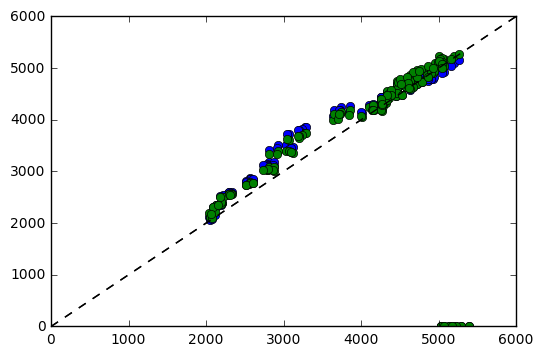

In [13]:
# Compare the predictions to the actual data:
plt.plot(data_slice[..., 1:].ravel(), exp_predictions.ravel(), 'o')
plt.plot([0, 6000], [0, 6000], 'k--')

plt.plot(data_slice[..., 1:].ravel(), ivim_predictions.ravel(), 'o')
plt.plot([0, 6000], [0, 6000], 'k--')

In [14]:
print("Mean NMSE for IVIM: ", ivim_nmse.mean())
print("Mean NMSE for exponential decay model:", exp_nmse.mean())

Mean NMSE for IVIM:  8.73595704886e-05
Mean NMSE for exponential decay model: 0.000118121220667
